<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab_CHP_Landsat_ANN_simple_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5
* Version con re-entrenamiento del modelo pre-entrenado
* Versión con la estandarizaciíón de datos con StandardScaler
* Version con un post-entranemiento del modelo pre-entrenado
* Clasificación en tres clases (no-urbano, urbano, agua)

In [ ]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [ ]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [8]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/CHP_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/CHP_2020_feature_L8_6b.npy')
array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/CHP_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/CHP_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/CHP_2000_feature_L5_6b.npy')
array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/CHP_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [9]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [32]:
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2020 = feature_transform(array_feature_2020)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(6, 234, 645)
(150930, 6)
(1, 234, 645)
(150930, 1)
(1, 234, 645)
(150930, 1)


Estandarización de datos

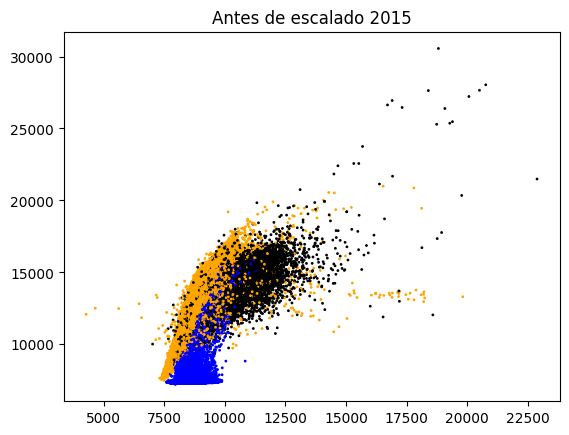

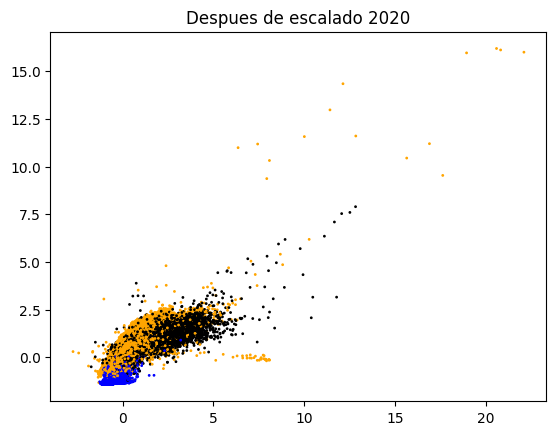

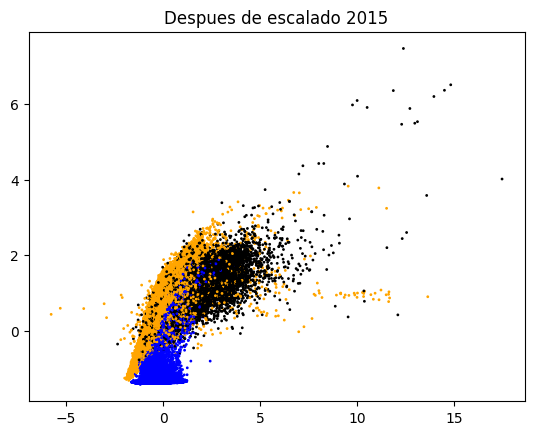

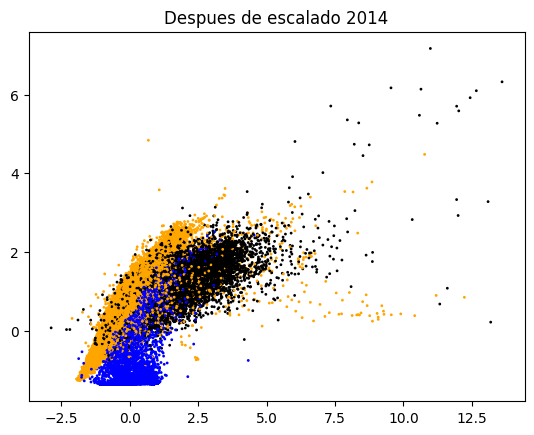

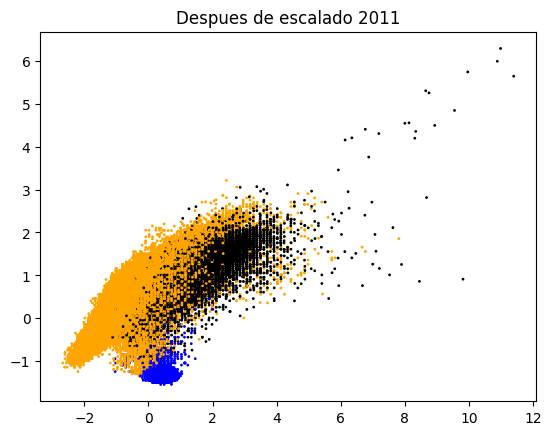

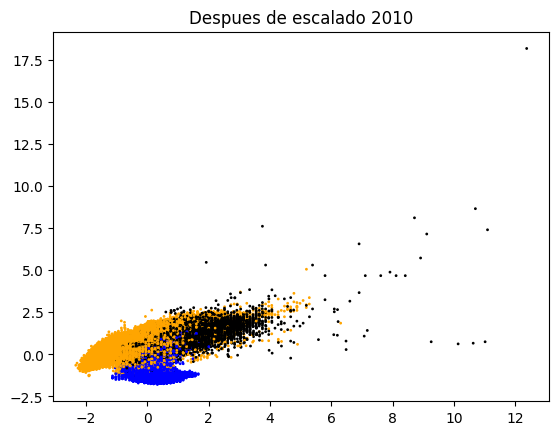

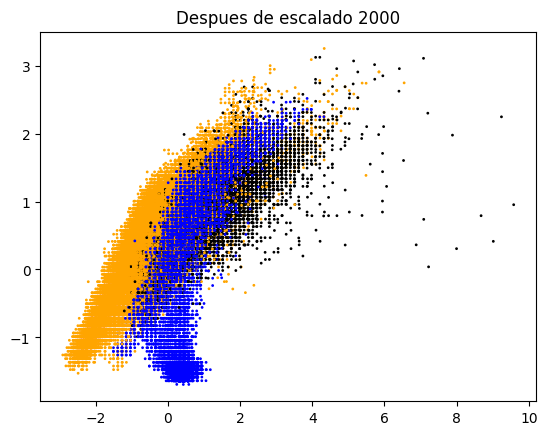

In [33]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(0,150930)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [12]:
print(x_features_2015)
print(y_labels_2015)

[[ 0.73324324  0.98116103  1.79653454  1.2699621   1.87713955  1.7875657 ]
 [ 0.53696815  0.5713919   1.51541929  1.03984612  1.58992771  1.59273453]
 [ 0.25568219  0.24105792  0.85134765  0.84793472  1.23173823  1.26471798]
 ...
 [-1.08948979  0.09574971 -0.62156157 -1.62410915 -1.49072188 -1.37235244]
 [-1.06448659  0.09090611 -0.61230329 -1.62618227 -1.49264763 -1.36892768]
 [-1.05948595  0.10931181 -0.60893664 -1.62558995 -1.49374806 -1.36778609]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Subdividir datos de entrenamiento y control (2015)

In [14]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.2, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(120744, 6)
(120744, 1)
(30186, 6)
(30186, 1)
[[ 0.69948892  0.50745629  1.30163704  0.75938301  1.43064069  1.48732782]
 [ 0.16067004  0.46483255  1.07438819  2.18479899  1.13517563  0.88799363]
 [-0.44940796 -0.46223378  0.17044276  0.15610598  0.34121647  0.34916366]
 ...
 [ 0.35694513  0.42027137  0.46923291  1.30402045  0.92664443  0.70267569]
 [ 1.8671382   1.71157692  2.15760771  1.79564532  1.1106911   1.08853275]
 [ 0.82825539  1.03347198  0.19905928 -1.3469038  -1.43239917 -1.34761802]]
[[0]
 [2]
 [0]
 ...
 [0]
 [2]
 [1]]
(120744, 1, 6) (30186, 1, 6)


Continuar entrenamiento de la red neuronal (ANN) simple pre-entrenada

In [16]:
from tensorflow import keras
from keras.models import load_model

## Cargar un modelo preentrenado
model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

print(model.summary())

# Continuar entrenamiento del modelo con datos adicionales
model.fit(xTrain, yTrain, epochs=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
3774/3774 [==============================] - 20s 5ms/step - loss: 0.1499 - accuracy: 0.9444
Epoch 2/5
3774/3774 [==============================

In [17]:
model.save('/content/drive/MyDrive/Colab Data/CHP_2015_model_ANN_2hl_3class_posentrenado.tensorflow')

In [18]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

944/944 [==============================] - 1s 1ms/step


In [19]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[18051    28   487]
 [  261  8329    68]
 [  704    12  2246]]

Exactitud (accuracy): 0.948,

Kappa de Cohen: 0.901,

Clase 1. Selectividad (precision): 0.949, especificidad (recall): 0.972, f1: 0.961

Clase 2. Selectividad (precision): 0.995, especificidad (recall): 0.962, f1: 0.978

Clase 3. Selectividad (precision): 0.802, especificidad (recall): 0.758, f1: 0.779


Predicción para datos de 2015

In [20]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

4717/4717 [==============================] - 10s 2ms/step
[[9.8973161e-01 4.1972784e-05 1.0226343e-02]
 [9.9479336e-01 2.0660782e-05 5.1860032e-03]
 [9.8691255e-01 1.8620437e-04 1.2901199e-02]
 ...
 [2.1929995e-06 9.9999779e-01 8.0221323e-23]
 [2.2899014e-06 9.9999774e-01 1.0593436e-22]
 [2.0619902e-06 9.9999797e-01 7.7404275e-23]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

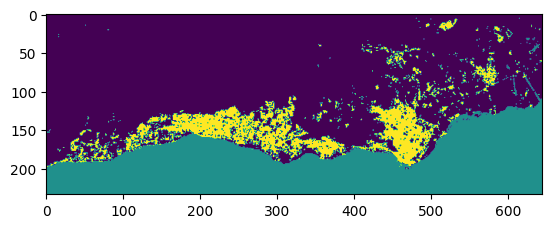

In [46]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

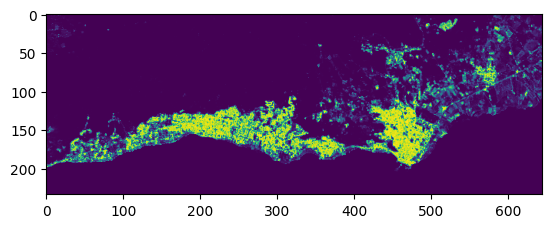

In [22]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [23]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

4717/4717 [==============================] - 7s 1ms/step
[[8.2682019e-01 4.4375080e-05 1.7313536e-01]
 [9.7697258e-01 1.3137778e-04 2.2896031e-02]
 [9.1415292e-01 4.3583270e-03 8.1488587e-02]
 ...
 [3.4445833e-07 9.9999958e-01 1.1572544e-20]
 [5.5408520e-07 9.9999940e-01 2.9780231e-20]
 [4.5010398e-07 9.9999952e-01 1.5107441e-20]]


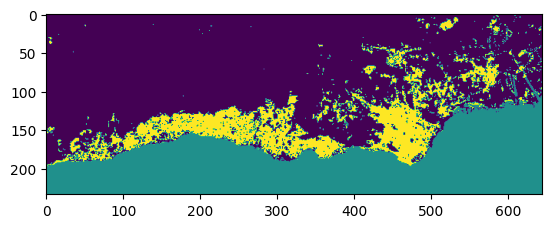

In [24]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

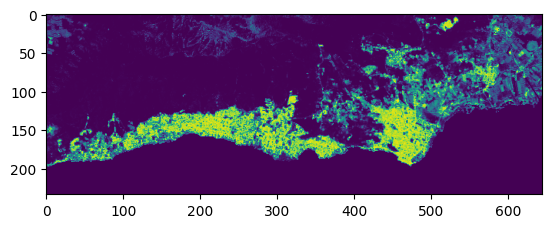

In [25]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [26]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

4717/4717 [==============================] - 8s 2ms/step
[[9.9843311e-01 4.2723161e-05 1.5240374e-03]
 [9.9629706e-01 1.4074554e-04 3.5621717e-03]
 [9.9925971e-01 2.2688819e-05 7.1764959e-04]
 ...
 [1.6786071e-06 9.9999827e-01 3.2395566e-22]
 [1.5828359e-06 9.9999845e-01 3.5790844e-22]
 [1.7796232e-06 9.9999821e-01 5.5342654e-22]]


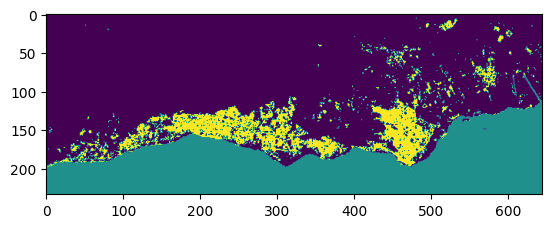

In [27]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

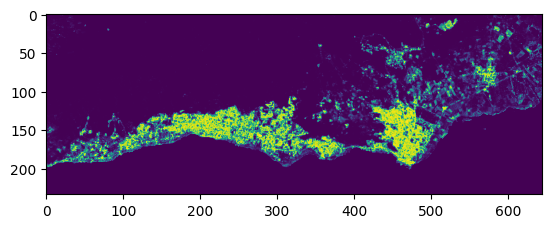

In [28]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [29]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/CHP_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/CHP_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/CHP_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/CHP_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/CHP_2020_prediction_urbano_float.npy', prediction_2020_urbano)

Preparar datos binarios 2014 para uso como target en modelo L5

In [34]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2014_class.reshape(x_features_2014_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

(150930, 1, 6) (150930, 1)


Posentrenar modelo L5

In [35]:
## Cargar un modelo preentrenado
model1 = load_model('/content/drive/MyDrive/Colab Data/GDL_2011_model_ANN_2hl_3class.tensorflow')

print(model1.summary())

# Posentrenar con datos 2011
model1.fit(x_features_2011_n, y_target_2011_n, epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
4717/4717 [==============================] - 10s 2ms/step - loss: 0.1336 - accuracy: 0.9495
Epoch 2/5
4717/4717 [============================

In [42]:
model.save('/content/drive/MyDrive/Colab Data/CHP_2011_model_ANN_2hl_3class_posentrenado.tensorflow')

Prediccion 2011

In [36]:
predicted_2011 = model1.predict(x_features_2011_n)
print(predicted_2011)

4717/4717 [==============================] - 9s 2ms/step
[[9.9915344e-01 1.6160059e-11 8.4648497e-04]
 [9.9642944e-01 1.6471442e-09 3.5705634e-03]
 [9.9553955e-01 1.0221307e-07 4.4602240e-03]
 ...
 [4.3440650e-05 9.9994093e-01 1.5637694e-05]
 [1.1126213e-04 9.9984825e-01 4.0491399e-05]
 [7.1922975e-04 9.9913472e-01 1.4596627e-04]]


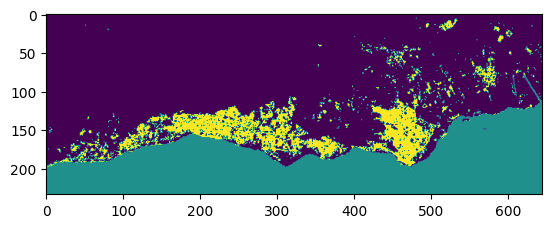

In [37]:
predicted_2011_class = predicted_2011.argmax(axis=-1)
predicted_2011_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2011_class_re[:,:])
plt.show()

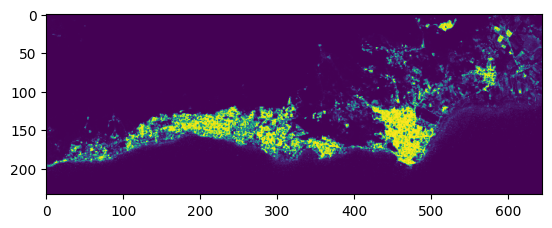

In [38]:
prediction_2011_urbano = np.reshape(predicted_2011[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2011 = (prediction_2011_urbano).astype('float')
plt.imshow(B_img_pred_2011[:,:])
plt.show()

Prediccion 2010

In [39]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model1.predict(x_features_2010_n)
print(predicted_2010)

4717/4717 [==============================] - 9s 2ms/step
[[9.9920624e-01 6.8047352e-12 7.9380674e-04]
 [9.9821723e-01 7.0140799e-10 1.7828005e-03]
 [9.9395597e-01 1.9023258e-07 6.0437066e-03]
 ...
 [1.0240189e-02 9.6530300e-01 2.4456741e-02]
 [9.0659857e-03 9.6805757e-01 2.2876507e-02]
 [1.6480487e-02 9.4909096e-01 3.4428537e-02]]


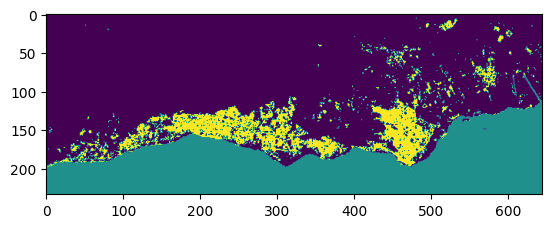

In [40]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

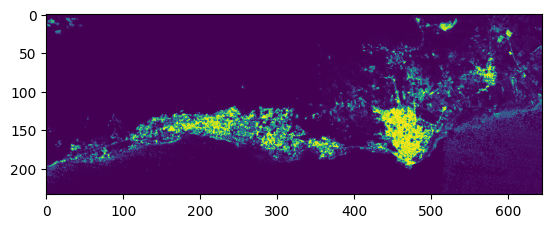

In [47]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

Prediccion 2000

In [50]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model1.predict(x_features_2000_n)
print(predicted_2000)

4717/4717 [==============================] - 10s 2ms/step
[[9.9626589e-01 1.5414881e-07 3.7338955e-03]
 [9.9770784e-01 1.2880555e-07 2.2919697e-03]
 [9.9277270e-01 4.4866641e-07 7.2267293e-03]
 ...
 [8.4526883e-03 9.9057603e-01 9.7124139e-04]
 [2.9570974e-06 9.9999607e-01 9.3566734e-07]
 [4.6907815e-05 9.9994361e-01 9.4692650e-06]]


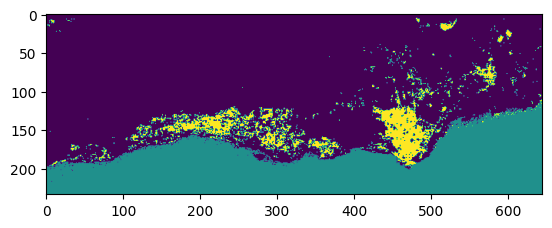

In [51]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

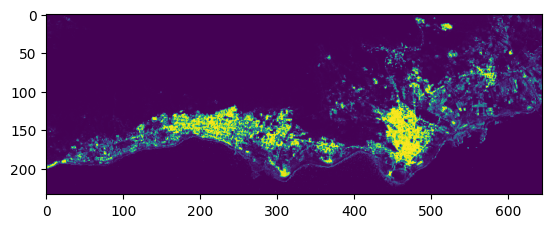

In [52]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()